In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
from datetime import datetime
import glob as gb
import re
import json
import gzip  
import scipy                  # http://scipy.org/
import scipy.odr, scipy.special, scipy.stats , scipy.interpolate
import sys

from IPython.display import Image  
%matplotlib inline
params = {'legend.fontsize': 24,
          'figure.figsize': (15, 5),
         'axes.labelsize': 24,
         'axes.titlesize': 24,
         'xtick.labelsize':24,
         'ytick.labelsize':24}
plt.rcParams.update(params)

In [2]:
K = 64 # number of OFDM subcarriers

In [3]:
CP = K//4  # length of the cyclic prefix: 25% of the block
print(CP)

16


In [4]:
P = 8 # number of pilot carriers per OFDM block
pilotValue = 3+3j # The known value each pilot transmits

allCarriers:   [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
pilotCarriers: [ 0  8 16 24 32 40 48 56 63]
dataCarriers:  [ 1  2  3  4  5  6  7  9 10 11 12 13 14 15 17 18 19 20 21 22 23 25 26 27
 28 29 30 31 33 34 35 36 37 38 39 41 42 43 44 45 46 47 49 50 51 52 53 54
 55 57 58 59 60 61 62]


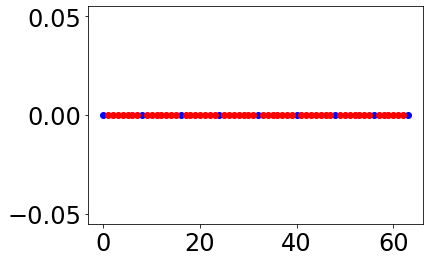

In [5]:
allCarriers = np.arange(K)  # indices of all subcarriers ([0, 1, ... K-1])

pilotCarriers = allCarriers[::K//P] # Pilots is every (K/P)th carrier.

# For convenience of channel estimation, let's make the last carriers also be a pilot
pilotCarriers = np.hstack([pilotCarriers, np.array([allCarriers[-1]])])
P = P+1

# data carriers are all remaining carriers
dataCarriers = np.delete(allCarriers, pilotCarriers)

print ("allCarriers:   %s" % allCarriers)
print ("pilotCarriers: %s" % pilotCarriers)
print ("dataCarriers:  %s" % dataCarriers)
plt.plot(pilotCarriers, np.zeros_like(pilotCarriers), 'bo', label='pilot')
plt.plot(dataCarriers, np.zeros_like(dataCarriers), 'ro', label='data')
plt.show()

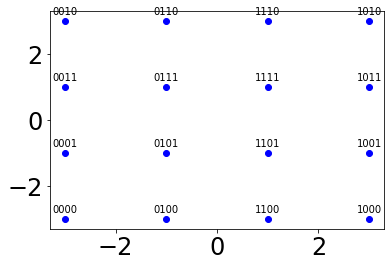

In [6]:
mu = 4 # bits per symbol (i.e. 16QAM)
payloadBits_per_OFDM = len(dataCarriers)*mu  # number of payload bits per OFDM symbol

mapping_table = {
    (0,0,0,0) : -3-3j,
    (0,0,0,1) : -3-1j,
    (0,0,1,0) : -3+3j,
    (0,0,1,1) : -3+1j,
    (0,1,0,0) : -1-3j,
    (0,1,0,1) : -1-1j,
    (0,1,1,0) : -1+3j,
    (0,1,1,1) : -1+1j,
    (1,0,0,0) :  3-3j,
    (1,0,0,1) :  3-1j,
    (1,0,1,0) :  3+3j,
    (1,0,1,1) :  3+1j,
    (1,1,0,0) :  1-3j,
    (1,1,0,1) :  1-1j,
    (1,1,1,0) :  1+3j,
    (1,1,1,1) :  1+1j
}
for b3 in [0, 1]:
    for b2 in [0, 1]:
        for b1 in [0, 1]:
            for b0 in [0, 1]:
                B = (b3, b2, b1, b0)
                Q = mapping_table[B]
                plt.plot(Q.real, Q.imag, 'bo')
                plt.text(Q.real, Q.imag+0.2, "".join(str(x) for x in B), ha='center')


In [7]:
demapping_table = {v : k for k, v in mapping_table.items()}
print(demapping_table)

{(-3-3j): (0, 0, 0, 0), (-3-1j): (0, 0, 0, 1), (-3+3j): (0, 0, 1, 0), (-3+1j): (0, 0, 1, 1), (-1-3j): (0, 1, 0, 0), (-1-1j): (0, 1, 0, 1), (-1+3j): (0, 1, 1, 0), (-1+1j): (0, 1, 1, 1), (3-3j): (1, 0, 0, 0), (3-1j): (1, 0, 0, 1), (3+3j): (1, 0, 1, 0), (3+1j): (1, 0, 1, 1), (1-3j): (1, 1, 0, 0), (1-1j): (1, 1, 0, 1), (1+3j): (1, 1, 1, 0), (1+1j): (1, 1, 1, 1)}


In [8]:
channelResponse = np.array([1, 0, 0.3+0.3j])  # the impulse response of the wireless channel
print(channelResponse, K)


H_exact = np.fft.fft(channelResponse,K)
print(H_exact)
#plt.plot(allCarriers, abs(H_exact))

SNRdb = 25  # signal to noise-ratio in dB at the receiver 

[1. +0.j  0. +0.j  0.3+0.3j] 64
[1.3       +3.00000000e-01j 1.35276268+2.35708488e-01j
 1.39196889+1.62358830e-01j 1.41611195+8.27698138e-02j
 1.42426407+8.80288308e-18j 1.41611195-8.27698138e-02j
 1.39196889-1.62358830e-01j 1.35276268-2.35708488e-01j
 1.3       -3.00000000e-01j 1.23570849-3.52762681e-01j
 1.16235883-3.91968889e-01j 1.08276981-4.16111954e-01j
 1.        -4.24264069e-01j 0.91723019-4.16111954e-01j
 0.83764117-3.91968889e-01j 0.76429151-3.52762681e-01j
 0.7       -3.00000000e-01j 0.64723732-2.35708488e-01j
 0.60803111-1.62358830e-01j 0.58388805-8.27698138e-02j
 0.57573593-8.80288308e-18j 0.58388805+8.27698138e-02j
 0.60803111+1.62358830e-01j 0.64723732+2.35708488e-01j
 0.7       +3.00000000e-01j 0.76429151+3.52762681e-01j
 0.83764117+3.91968889e-01j 0.91723019+4.16111954e-01j
 1.        +4.24264069e-01j 1.08276981+4.16111954e-01j
 1.16235883+3.91968889e-01j 1.23570849+3.52762681e-01j
 1.3       +3.00000000e-01j 1.35276268+2.35708488e-01j
 1.39196889+1.62358830e-01j 1.416

Bits count:  220
First 20 bits:  [1 0 0 0 1 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1]
Mean of bits (should be around 0.5):  0.5272727272727272


/home/aalmela/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  """


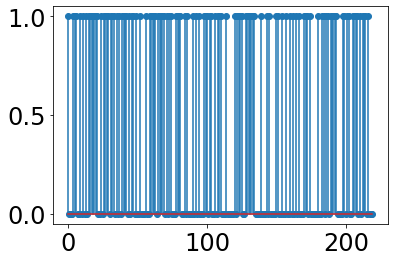

In [9]:
bits = np.random.binomial(n=1, p=0.5, size=(payloadBits_per_OFDM, ))
print ("Bits count: ", len(bits))
print ("First 20 bits: ", bits[:20])
print ("Mean of bits (should be around 0.5): ", np.mean(bits))
plt.stem(bits)
plt.show()

In [10]:
def SP(bits): #serie a paralelo
    return bits.reshape((len(dataCarriers), mu))

bits_SP = SP(bits)
print ("First 5 bit groups")
print (bits_SP[:5,:])


First 5 bit groups
[[1 0 0 0]
 [1 1 1 0]
 [0 1 0 1]
 [0 1 0 1]
 [1 1 1 1]]


In [11]:
def Mapping(bits):
    return np.array([mapping_table[tuple(b)] for b in bits])
QAM = Mapping(bits_SP)
print ("First 5 QAM symbols and bits:")
print (bits_SP[:5,:])
print (QAM[:5])



First 5 QAM symbols and bits:
[[1 0 0 0]
 [1 1 1 0]
 [0 1 0 1]
 [0 1 0 1]
 [1 1 1 1]]
[ 3.-3.j  1.+3.j -1.-1.j -1.-1.j  1.+1.j]


In [12]:
def OFDM_symbol(QAM_payload):
    symbol = np.zeros(K, dtype=complex) # the overall K subcarriers
    symbol[pilotCarriers] = pilotValue  # allocate the pilot subcarriers 
    symbol[dataCarriers] = QAM_payload  # allocate the pilot subcarriers
    return symbol
OFDM_data = OFDM_symbol(QAM)
print ("Number of OFDM carriers in frequency domain: ", len(OFDM_data))
print(OFDM_data)

Number of OFDM carriers in frequency domain:  64
[ 3.+3.j  3.-3.j  1.+3.j -1.-1.j -1.-1.j  1.+1.j  1.-3.j  3.+1.j  3.+3.j
  1.-1.j  1.-1.j -1.-1.j  1.+3.j  3.+1.j -1.-3.j  3.-3.j  3.+3.j  3.-1.j
  1.+1.j -1.+1.j  1.-1.j -1.+3.j -3.+1.j  1.-3.j  3.+3.j  3.+3.j -3.+3.j
  3.+3.j -3.+1.j  3.+1.j -3.+3.j  1.+3.j  3.+3.j -3.+3.j -3.-3.j  3.+1.j
  1.-3.j  1.+1.j  1.+3.j -3.-1.j  3.+3.j -3.-1.j -1.-3.j -3.+1.j -3.+3.j
 -1.-3.j  3.+3.j  3.+3.j  3.+3.j -3.+1.j  3.+3.j -3.-3.j  3.-1.j  3.+1.j
 -1.+1.j  1.-3.j  3.+3.j -3.+1.j -1.+3.j -1.+1.j  3.+3.j  1.+3.j  3.-3.j
  3.+3.j]


In [13]:
def IDFT(OFDM_data):
    return np.fft.ifft(OFDM_data)
OFDM_time = IDFT(OFDM_data)
print ("Number of OFDM samples in time-domain before CP: ", len(OFDM_time))

Number of OFDM samples in time-domain before CP:  64


In [14]:
def addCP(OFDM_time):
    cp = OFDM_time[-CP:]               # take the last CP samples ...
    return np.hstack([cp, OFDM_time])  # ... and add them to the beginning
OFDM_withCP = addCP(OFDM_time)
print ("Number of OFDM samples in time domain with CP: ", len(OFDM_withCP))

Number of OFDM samples in time domain with CP:  80


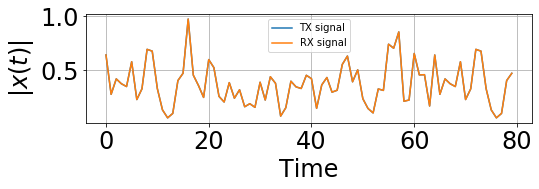

In [15]:
def channel(signal):
    convolved = np.convolve(signal, channelResponse)
    signal_power = np.mean(abs(convolved**2))
    sigma2 = signal_power * 10**(-SNRdb/10)  # calculate noise power based on signal power and SNR
    
    print ("RX Signal power: %.4f. Noise power: %.4f" % (signal_power, sigma2))
    
    # Generate complex noise with given variance
    noise = np.sqrt(sigma2/2) * (np.random.randn(*convolved.shape)+1j*np.random.randn(*convolved.shape))
    return convolved #+ noise
OFDM_TX = OFDM_withCP
OFDM_RX = OFDM_TX #channel(OFDM_TX)
plt.figure(figsize=(8,2))
plt.plot(abs(OFDM_TX), label='TX signal')
plt.plot(abs(OFDM_RX), label='RX signal')
plt.legend(fontsize=10)
plt.xlabel('Time'); plt.ylabel('$|x(t)|$');
plt.grid(True);

In [16]:
def removeCP(signal):
    return signal[CP:(CP+K)]
OFDM_RX_noCP = removeCP(OFDM_RX)

In [17]:
def DFT(OFDM_RX):
    return np.fft.fft(OFDM_RX)
OFDM_demod = DFT(OFDM_RX_noCP)

/home/aalmela/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  del sys.path[0]


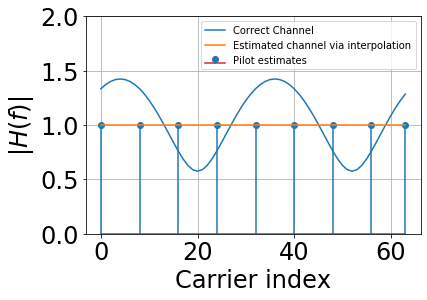

In [18]:
def channelEstimate(OFDM_demod):
    pilots = OFDM_demod[pilotCarriers]  # extract the pilot values from the RX signal
    Hest_at_pilots = pilots / pilotValue # divide by the transmitted pilot values
    
    # Perform interpolation between the pilot carriers to get an estimate
    # of the channel in the data carriers. Here, we interpolate absolute value and phase 
    # separately
    Hest_abs = scipy.interpolate.interp1d(pilotCarriers, abs(Hest_at_pilots), kind='linear')(allCarriers)
    Hest_phase = scipy.interpolate.interp1d(pilotCarriers, np.angle(Hest_at_pilots), kind='linear')(allCarriers)
    Hest = Hest_abs * np.exp(1j*Hest_phase)
    
    plt.plot(allCarriers, abs(H_exact), label='Correct Channel')
    plt.stem(pilotCarriers, abs(Hest_at_pilots), label='Pilot estimates')
    plt.plot(allCarriers, abs(Hest), label='Estimated channel via interpolation')
    plt.grid(True); plt.xlabel('Carrier index'); plt.ylabel('$|H(f)|$'); plt.legend(fontsize=10)
    plt.ylim(0,2)
    
    return Hest
Hest = channelEstimate(OFDM_demod)